# 🧠 MODEL EFFICIENTNET-B0 UNTUK KLASIFIKASI AFLATOKSIN

## Mengapa EfficientNet-B0?

| Aspek | ResNet50 | EfficientNet-B0 | Keuntungan |
|-------|----------|-----------------|------------|
| **Parameter** | 25.6 juta | 5.3 juta | 5x lebih kecil → kurang overfitting |
| **Top-1 ImageNet** | 76.0% | 77.1% | Lebih akurat dengan parameter lebih sedikit |
| **FLOPS** | 4.1B | 0.39B | 10x lebih efisien |

## Perubahan Utama dari ResNet50:

1. **Arsitektur dasar**: `ResNet50` → `EfficientNetB0`
2. **Classifier head lebih sederhana**: `[512, 256, 64]` → `[256]` (1 layer saja)
3. **Fine-tune layer**: Layer 140+ → Layer ~200+ (lebih sedikit layer di-unfreeze)
4. **Learning rate lebih konservatif**: Karena model lebih kecil

---

In [14]:
# =============================================================================
# CELL 2: IMPORT LIBRARIES UNTUK MODEL
# =============================================================================
%run preprocess.ipynb
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import ( Dense, GlobalAveragePooling2D, Dropout, Input,BatchNormalization )
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)

==================PROSES PEMUATAN DATASET==================

[1/3] Memuat dataset_final\train
Found 1400 files belonging to 4 classes.

[2/3] Memuat dataset_final\val
Found 131 files belonging to 4 classes.

[3/3] Memuat dataset_final\test
Found 132 files belonging to 4 classes.

==================INFORMASI KELAS & MAPPING==================
Kelas ditemukan: ['1', '2', '3', '4']

Index Model     | Nama Folder     | Nilai PPB (Target)  
------------------------------------------------------------
0               | 1               | 1                        
1               | 2               | 2                        
2               | 3               | 3                        
3               | 4               | 4                        

Selesai. Dataset siap digunakan.
Step 2: Setting up data augmentation...
✓ RandomFlip (horizontal)
✓ RandomRotation (±10°)
Menerapkan preprocessing ke dataset...
✓ Training dataset: augmentation ON, cache ON, prefetch ON
✓ Validation dataset: augmenta

In [15]:
# =============================================================================
# CELL 3: FOCAL LOSS (OPSIONAL - UNTUK IMBALANCED DATA)
# =============================================================================

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, name='focal_loss'):
        """
        Args:
            alpha: Bobot balancing (default 1.0)
            gamma: Focusing parameter (default 2.0)
                   - Semakin besar gamma, semakin fokus pada sampel sulit
        """
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # Clip prediksi untuk mencegah log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Hitung cross entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Hitung focal weight: (1 - p)^gamma
        # p adalah probabilitas untuk kelas yang benar
        pt = y_true * y_pred  # Ambil probabilitas kelas benar
        pt = tf.reduce_sum(pt, axis=-1, keepdims=True)
        focal_weight = tf.pow(1.0 - pt, self.gamma)
        
        # Gabungkan: α * (1-p)^γ * CE
        focal_loss = self.alpha * focal_weight * tf.reduce_sum(ce, axis=-1, keepdims=True)
        
        return tf.reduce_mean(focal_loss)

In [16]:
# =============================================================================
# CELL 4: KONFIGURASI EKSPERIMEN
# =============================================================================

# Layer Dense setelah GlobalAveragePooling
DENSE_UNITS = 256
DROPOUT_RATE = 0.5 # Semakin tinggi = regularisasi lebih kuat

# Fine-tune dari layer ke berapa? EfficientNet-B0 punya ~237 layers
# Untuk dataset kecil, unfreeze sedikit layer saja (misal mulai dari 200)
FINE_TUNE_AT = 170 # Semakin tinggi angka = semakin sedikit layer yang di-unfreeze

# TRAINING PHASE 1: Feature Extraction (Base Model Frozen)
LR_PHASE_1 = 5e-5 
EPOCHS_PHASE_1 = 20

# TRAINING PHASE 2: Fine-Tuning (Sebagian Base Model Unfrozen)
LR_PHASE_2 = 1e-5 # HARUS jauh lebih kecil untuk mencegah "catastrophic forgetting"
EPOCHS_PHASE_2 = 30

BATCH_SIZE = 32             # Jumlah gambar yang diproses sekali jalan.
OPTIMIZER_NAME = 'Adam'     # Pilihan: 'Adam', 'SGD', 'RMSprop'.

# LOSS FUNCTION
LOSS_TYPE = 'crossentropy'  # 'focal' atau 'crossentropy'
LABEL_SMOOTHING = 0.1
FOCAL_ALPHA = 1.0
FOCAL_GAMMA = 2.0

USE_CLASS_WEIGHTS = True  # Gunakan class weights untuk menangani imbalance
CLASS_WEIGHTS = {
    0:1.18,
    1:0.81,
    2:1.05,
    3:1.67
}

# Nama file untuk menyimpan model terbaik
MODEL_SAVE_PATH = 'best_efficientnet_aflatoxin.keras'

# File log untuk mencatat semua eksperimen
LOG_FILE_PATH = 'experiment_log_efficientnet.csv'

In [17]:
# =============================================================================
# CELL 5: MEMBANGUN MODEL EFFICIENTNET-B0
# =============================================================================

def build_efficientnet_model():
    
    # 1. Load EfficientNet-B0 pre-trained
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    # 2. Freeze base model (Phase 1)
    base_model.trainable = False
    
    # 3. Bangun classifier head
    # Input layer
    inputs = Input(shape=(img_height, img_width, 3), name='input_layer')
    
    # Pass through EfficientNet
    # training=False: BatchNorm layers dalam mode inference
    x = base_model(inputs, training=False)
    
    # Global Average Pooling
    # Mengubah output (7, 7, 1280) menjadi (1280,)
    # Alternatif: GlobalMaxPooling2D atau Flatten
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Dense layer dengan ReLU activation
    x = Dense(DENSE_UNITS, activation='relu', name='dense_1')(x)
    
    # Dropout untuk regularisasi
    x = Dropout(DROPOUT_RATE, name='dropout')(x)
    
    # Output layer dengan Softmax
    # 4 neuron untuk 4 kelas (1 PPB, 2 PPB, 3 PPB, 4 PPB)
    outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)
    
    # -------------------------------------------------------------------------
    # 4. Buat model
    # -------------------------------------------------------------------------
    model = Model(inputs=inputs, outputs=outputs, name='EfficientNetB0_Aflatoxin')
    
    return model, base_model

# Bangun model
model, base_model = build_efficientnet_model()

# Tampilkan informasi model
print("="*60)
print("MODEL BERHASIL DIBANGUN")
print("="*60)
print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")
print(f"\nBase model layers: {len(base_model.layers)}")

MODEL BERHASIL DIBANGUN

Total parameters: 4,378,535
Trainable parameters: 328,964
Non-trainable parameters: 4,049,571.0

Base model layers: 238


In [18]:
# CELL 7: COMPILE MODEL

# Pilih loss function
if LOSS_TYPE == 'focal':
    loss_fn = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
    loss_name = f"Focal Loss (α={FOCAL_ALPHA}, γ={FOCAL_GAMMA})"
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=LABEL_SMOOTHING
    )
    loss_name = f"Categorical Crossentropy (smoothing={LABEL_SMOOTHING})"

# Setup Optimizer Dinamis sesuai Konfigurasi
if OPTIMIZER_NAME.lower() == 'Adam':
    opt = Adam(learning_rate=LR_PHASE_1)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt = SGD(learning_rate=LR_PHASE_1)
elif OPTIMIZER_NAME.lower() == 'AdamW':
    opt = AdamW(learning_rate=LR_PHASE_1)
else:
    opt = RMSprop(learning_rate=LR_PHASE_1)
    
# Compile model
model.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=['accuracy'],
)

print("Model compiled!")
print(f"  - Optimizer: {OPTIMIZER_NAME} (lr={LR_PHASE_1})")
print(f"  - Loss: {loss_name}")
print(f"  - Metrics: accuracy")
print(f"Model compiled successfully!")

Model compiled!
  - Optimizer: Adam (lr=5e-05)
  - Loss: Categorical Crossentropy (smoothing=0.1)
  - Metrics: accuracy
Model compiled successfully!


In [ ]:
# =============================================================================
# CELL 8: SETUP CALLBACKS
# =============================================================================

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  ✓ EarlyStopping (patience=10, monitor=val_accuracy)")
print("  ✓ ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  ✓ ModelCheckpoint (save to: {MODEL_SAVE_PATH})")

Callbacks configured:
  ✓ EarlyStopping (patience=10, monitor=val_accuracy)
  ✓ ReduceLROnPlateau (factor=0.5, patience=5)
  ✓ ModelCheckpoint (save to: best_efficientnet_aflatoxin.keras)


In [20]:
# =============================================================================
# CELL 9: PHASE 1 - FEATURE EXTRACTION
# =============================================================================
#
# TUJUAN: Melatih classifier head sementara base model dibekukan
#
# MENGAPA 2 PHASE?
# 1. Phase 1: Classifier head belajar menggunakan fitur dari EfficientNet
#    - Base model sudah punya fitur bagus dari ImageNet
#    - Kita hanya perlu melatih bagaimana menggunakan fitur tersebut
#
# 2. Phase 2: Fine-tune sebagian base model
#    - Setelah head sudah bagus, kita "tune" fitur untuk domain spesifik
#    - LR sangat kecil agar tidak merusak fitur yang sudah bagus
# =============================================================================

print("="*60)
print("PHASE 1: FEATURE EXTRACTION")
print("="*60)
print(f"\nBase model: FROZEN")
print(f"Training: Classifier head only")
print(f"Learning rate: {LR_PHASE_1}")
print(f"Epochs: {EPOCHS_PHASE_1}")
print("\nStarting training...\n")

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE_1,
    callbacks=callbacks,
    verbose=1,
    class_weight=CLASS_WEIGHTS if USE_CLASS_WEIGHTS else None
)

# Simpan hasil Phase 1
best_val_acc_p1 = max(history_phase1.history['val_accuracy'])
print(f"\n✓ Phase 1 Complete!")
print(f"✓ Best Validation Accuracy: {best_val_acc_p1:.4f}")

PHASE 1: FEATURE EXTRACTION

Base model: FROZEN
Training: Classifier head only
Learning rate: 5e-05
Epochs: 20

Starting training...

Epoch 1/20


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.2517 - loss: 1.6603
Epoch 1: val_accuracy improved from -inf to 0.16794, saving model to best_efficientnet_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.2524 - loss: 1.6592 - val_accuracy: 0.1679 - val_loss: 1.4443 - learning_rate: 5.0000e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3269 - loss: 1.5649
Epoch 2: val_accuracy improved from 0.16794 to 0.25191, saving model to best_efficientnet_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 424ms/step - accuracy: 0.3274 - loss: 1.5643 - val_accuracy: 0.2519 - val_loss: 1.4273 - learning_rate: 5.0000e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.3622 - loss: 1.5156
Epoch 3: val_accuracy improved from 0.25191 to 0.26718, saving model to best_efficientnet_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.3624 - loss: 1.5153 - val_accuracy: 0.2672 - val_loss: 1.3982 - learning_rate: 5.0000e-05


In [22]:
# =============================================================================
# CELL 10: UNFREEZE BASE MODEL UNTUK FINE-TUNING
# =============================================================================
#
# STRATEGI FINE-TUNING:
#
# EfficientNet-B0 memiliki ~237 layers
# Layer awal: mendeteksi fitur umum (edges, textures)
# Layer akhir: mendeteksi fitur spesifik (patterns, objects)
#
# Untuk dataset kecil:
# - Freeze layer awal (fitur umum sudah bagus)
# - Unfreeze hanya beberapa layer akhir
# - FINE_TUNE_AT = 200 berarti layer 0-199 tetap frozen
# =============================================================================

print("="*60)
print("PREPARING PHASE 2: FINE-TUNING")
print("="*60)

# Unfreeze base model
base_model.trainable = True

# Freeze layer awal, unfreeze layer akhir
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

# Hitung statistik
total_layers = len(base_model.layers)
frozen_layers = FINE_TUNE_AT
trainable_layers = total_layers - FINE_TUNE_AT

print(f"\nBase model layers: {total_layers}")
print(f"Frozen layers: {frozen_layers} (0 to {FINE_TUNE_AT-1})")
print(f"Trainable layers: {trainable_layers} ({FINE_TUNE_AT} to {total_layers-1})")

if OPTIMIZER_NAME.lower() == 'Adam':
    opt_ft = Adam(learning_rate=LR_PHASE_2)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt_ft = SGD(learning_rate=LR_PHASE_2)
elif OPTIMIZER_NAME.lower() == 'AdamW':
    opt_ft = AdamW(learning_rate=LR_PHASE_2)
else:
    opt_ft = RMSprop(learning_rate=LR_PHASE_2)
    
# Re-compile dengan learning rate lebih kecil
# PENTING: Harus re-compile setelah mengubah trainable status
model.compile(
    optimizer=opt_ft,
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"\n✓ Model re-compiled with LR={LR_PHASE_2}")
print(f"\nTrainable parameters now: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

PREPARING PHASE 2: FINE-TUNING

Base model layers: 238
Frozen layers: 170 (0 to 169)
Trainable layers: 68 (170 to 237)

✓ Model re-compiled with LR=1e-05

Trainable parameters now: 3,389,952


In [23]:
# =============================================================================
# CELL 11: PHASE 2 - FINE-TUNING
# =============================================================================

print("="*60)
print("PHASE 2: FINE-TUNING")
print("="*60)
print(f"\nBase model: PARTIALLY UNFROZEN (from layer {FINE_TUNE_AT})")
print(f"Learning rate: {LR_PHASE_2}")
print(f"Epochs: {EPOCHS_PHASE_2}")
print("\nStarting fine-tuning...\n")

# Lanjutkan dari epoch terakhir Phase 1
initial_epoch = len(history_phase1.history['loss'])

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=initial_epoch,
    epochs=initial_epoch + EPOCHS_PHASE_2,
    callbacks=callbacks,
    verbose=1,
    class_weight=CLASS_WEIGHTS if USE_CLASS_WEIGHTS else None
)

# Simpan hasil Phase 2
best_val_acc_p2 = max(history_phase2.history['val_accuracy'])
print(f"\n✓ Phase 2 Complete!")
print(f"✓ Best Validation Accuracy: {best_val_acc_p2:.4f}")

PHASE 2: FINE-TUNING

Base model: PARTIALLY UNFROZEN (from layer 170)
Learning rate: 1e-05
Epochs: 30

Starting fine-tuning...

Epoch 21/50


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.3216 - loss: 1.6318
Epoch 21: val_accuracy did not improve from 0.38931
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 631ms/step - accuracy: 0.3221 - loss: 1.6309 - val_accuracy: 0.3893 - val_loss: 1.3010 - learning_rate: 1.0000e-05
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3605 - loss: 1.5459
Epoch 22: val_accuracy improved from 0.38931 to 0.42748, saving model to best_efficientnet_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.3608 - loss: 1.5453 - val_accuracy: 0.4275 - val_loss: 1.3209 - learning_rate: 1.0000e-05
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.3844 - loss: 1.4768
Epoch 23: val_accuracy improved from 0.42748 to 0.43511, saving model to best_efficientnet_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 619ms/step - accuracy: 0.3846 - loss: 1.4763 - val_accuracy: 0.4351 - val_loss: 1.3483 - learning_rate: 1.0000e-05
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms

In [24]:
print("Step 5: Evaluation on data set...")

# Load model terbaik
model = tf.keras.models.load_model('best_efficientnet_aflatoxin.keras')

# Evaluasi
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n✓ Test Loss: {test_loss:.4f}")
print(f"✓ Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Step 5: Evaluation on data set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.1302 - loss: 1.6986

✓ Test Loss: 1.5591
✓ Test Accuracy: 0.2121 (21.21%)


In [26]:
# =============================================================================
# CELL 13: EVALUASI PADA TEST SET
# =============================================================================
# Prediksi
print("\nMelakukan prediksi...")

print(f"\nTEST ACCURACY: {test_acc*100:.2f}%")


Melakukan prediksi...

TEST ACCURACY: 21.21%


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step


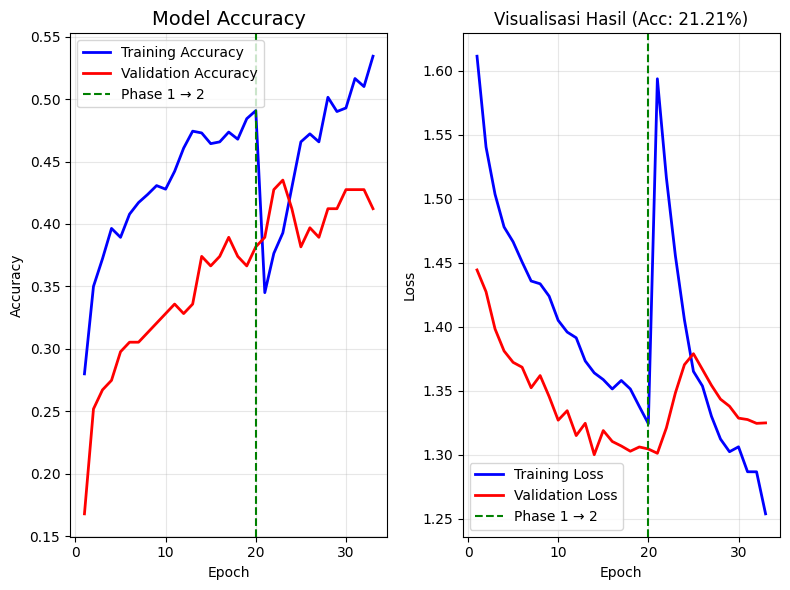

In [ ]:

# =============================================================================
# CELL 12: VISUALISASI TRAINING HISTORY
# =============================================================================
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ground truth
y_true_onehot = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

# Nama kelas untuk report
target_names = [f'Kelas {name})' for name in class_names]

# Hitung metrik
test_accuracy = accuracy_score(y_true, y_pred)


import matplotlib.pyplot as plt

# Gabungkan history dari kedua phase
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

epochs_range = range(1, len(acc) + 1)
phase1_end = len(history_phase1.history['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plot Accuracy
axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=phase1_end, color='green', linestyle='--', label='Phase 1 → 2')
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Loss
axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[1].axvline(x=phase1_end, color='green', linestyle='--', label='Phase 1 → 2')
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Siapkan Folder Penyimpanan Gambar
plot_folder = "visualizations_ENB0" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder) # Buat folder otomatis jika belum ada
# Buat Nama File Unik (Timestamp + Akurasi)
current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_{current_time_str}_Acc{test_accuracy*100:.1f}.png"
plotfilepath = os.path.join(plot_folder, plot_filename)

plt.savefig(plotfilepath, dpi=300, bbox_inches='tight')
plt.title(f'Visualisasi Hasil (Acc: {test_accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Kelas 1)     0.0000    0.0000    0.0000        28
    Kelas 2)     0.3077    0.0727    0.1176        55
    Kelas 3)     0.3000    0.3429    0.3200        35
    Kelas 4)     0.1519    0.8571    0.2581        14

    accuracy                         0.2121       132
   macro avg     0.1899    0.3182    0.1739       132
weighted avg     0.2239    0.2121    0.1612       132


Confusion Matrix:
[[ 0  9 10  9]
 [ 0  4 16 35]
 [ 0  0 12 23]
 [ 0  0  2 12]]
✅ Akurasi Test Akhir: 21.21%


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

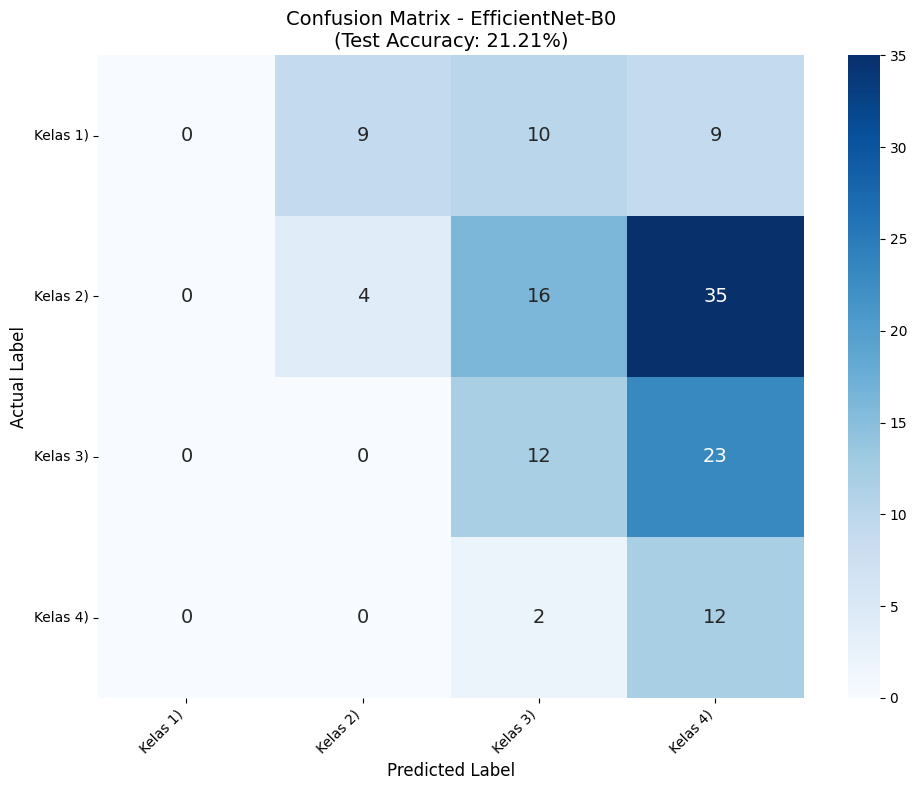


📊 Confusion matrix saved to: history_plots_ENB0\cm_20260130_122659_Acc21.2.png


In [28]:
# =============================================================================
# CELL 14: CLASSIFICATION REPORT & CONFUSION MATRIX
# =============================================================================

import seaborn as sns

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(
    y_true, 
    y_pred, 
    target_names=target_names, 
    digits=4,
    output_dict=True
)
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(cm)
print(f"✅ Akurasi Test Akhir: {test_accuracy*100:.2f}%")

# Siapkan Folder Penyimpanan Gambar
plot_folder = "history_plots_ENB0" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder) # Buat folder otomatis jika belum ada
# Buat Nama File Unik (Timestamp + Akurasi)
current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_{current_time_str}_Acc{test_accuracy*100:.1f}.png"
plot_filepath = os.path.join(plot_folder, plot_filename)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    annot_kws={'size': 14}
)
plt.title(f'Confusion Matrix - EfficientNet-B0\n(Test Accuracy: {test_accuracy*100:.2f}%)', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Simpan gambar
plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Confusion matrix saved to: {plot_filepath}")

In [29]:
# =============================================================================
# CELL 15: ANALISIS CONFIDENCE
# =============================================================================
#
# Confidence = seberapa "yakin" model dengan prediksinya
# High confidence + correct = bagus
# High confidence + wrong = berbahaya (overconfident)
# Low confidence = model ragu-ragu (mungkin data ambigu)
# =============================================================================

# Hitung confidence untuk setiap prediksi
confidence_scores = np.max(y_pred_probs, axis=1)

# Statistik
avg_confidence = np.mean(confidence_scores)
min_confidence = np.min(confidence_scores)
max_confidence = np.max(confidence_scores)
std_confidence = np.std(confidence_scores)

# Confidence untuk prediksi benar vs salah
correct_mask = (y_pred == y_true)
correct_confidence = np.mean(confidence_scores[correct_mask])
wrong_confidence = np.mean(confidence_scores[~correct_mask]) if (~correct_mask).sum() > 0 else 0

print("="*60)
print("ANALISIS CONFIDENCE")
print("="*60)
print(f"\nStatistik Overall:")
print(f"  - Average Confidence: {avg_confidence*100:.2f}%")
print(f"  - Min Confidence: {min_confidence*100:.2f}%")
print(f"  - Max Confidence: {max_confidence*100:.2f}%")
print(f"  - Std Confidence: {std_confidence*100:.2f}%")
print(f"\nConfidence by Prediction:")
print(f"  - Correct predictions: {correct_confidence*100:.2f}%")
print(f"  - Wrong predictions: {wrong_confidence*100:.2f}%")

# Interpretasi
if correct_confidence > wrong_confidence + 0.1:
    print("\n✓ Model lebih confident pada prediksi yang benar (bagus!)")
else:
    print("\n⚠️ Model cukup confident bahkan pada prediksi salah (hati-hati overconfidence)")

ANALISIS CONFIDENCE

Statistik Overall:
  - Average Confidence: 44.00%
  - Min Confidence: 29.03%
  - Max Confidence: 74.09%
  - Std Confidence: 9.05%

Confidence by Prediction:
  - Correct predictions: 46.82%
  - Wrong predictions: 43.24%

⚠️ Model cukup confident bahkan pada prediksi salah (hati-hati overconfidence)


In [30]:
# =============================================================================
# CELL 16: SIMPAN LOG EKSPERIMEN
# =============================================================================

# Buat dictionary dengan semua informasi eksperimen
log_data = {
    # Timestamp
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Arsitektur
    "Optimizer": OPTIMIZER_NAME,
    "Batch_Size": BATCH_SIZE,
    'Dense_Units': DENSE_UNITS,
    'Dropout': DROPOUT_RATE,
    'Fine_Tune_At': FINE_TUNE_AT,
    
    # Training params
    'LR_Phase_1': LR_PHASE_1,
    'Epochs_P1': EPOCHS_PHASE_1,
    'LR_Phase_2': LR_PHASE_2,
    'Epochs_P2': EPOCHS_PHASE_2,
    
    # Regularisasi
    'Loss_Type': LOSS_TYPE,
    'Label_Smoothing': LABEL_SMOOTHING if LOSS_TYPE == 'crossentropy' else 'N/A',
    'Focal_Gamma': FOCAL_GAMMA if LOSS_TYPE == 'focal' else 'N/A',
    
    # Hasil
    'Accuracy': round(test_accuracy, 4),
    'Avg_Confidence': round(avg_confidence, 4),
    'Confusion_Matrix': str(cm.tolist()),
}

# Tambahkan metrik per kelas
for name in target_names:
    log_data[f'{name}_Precision'] = round(report[name]['precision'], 4)
    log_data[f'{name}_Recall'] = round(report[name]['recall'], 4)
    log_data[f'{name}_F1'] = round(report[name]['f1-score'], 4)

# Simpan ke CSV
df_log = pd.DataFrame([log_data])

if os.path.exists(LOG_FILE_PATH):
    df_log.to_csv(LOG_FILE_PATH, mode='a', header=False, index=False)
    print(f"✓ Log ditambahkan ke: {LOG_FILE_PATH}")
else:
    df_log.to_csv(LOG_FILE_PATH, index=False)
    print(f"✓ File log baru dibuat: {LOG_FILE_PATH}")

print("\n" + "="*60)
print("EKSPERIMEN SELESAI")
print("="*60)
print(f"\n📁 Model tersimpan di: {MODEL_SAVE_PATH}")
print(f"📁 Log tersimpan di: {LOG_FILE_PATH}")
print(f"\n🎯 Test Accuracy: {test_accuracy*100:.2f}%")

✓ Log ditambahkan ke: experiment_log_efficientnet.csv

EKSPERIMEN SELESAI

📁 Model tersimpan di: best_efficientnet_aflatoxin.keras
📁 Log tersimpan di: experiment_log_efficientnet.csv

🎯 Test Accuracy: 21.21%


---

## 🔄 Langkah Selanjutnya

### Jika akurasi belum memuaskan, coba:

1. **Ubah FINE_TUNE_AT**: 
   - Lebih kecil (misal 150) = lebih banyak layer di-train = lebih adaptif tapi risiko overfitting
   - Lebih besar (misal 220) = lebih sedikit layer = lebih stable

2. **Ubah DENSE_UNITS**:
   - Coba [128] atau [512]
   
3. **Ubah DROPOUT_RATE**:
   - Naikan ke 0.6 jika overfitting
   - Turunkan ke 0.3 jika underfitting

4. **Coba loss function lain**:
   - Ubah LOSS_TYPE ke 'crossentropy' dengan LABEL_SMOOTHING=0.2

5. **Coba arsitektur lain**:
   - EfficientNet-B1 (sedikit lebih besar)
   - DenseNet-121
   - MobileNetV2

---